In [36]:
# System
import os
import random
import shutil

# Data preparation
import pandas as pd
import numpy as np
import math

# Plotting
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import svgutils.compose as sc
from IPython.display import SVG

# Calculations: Normalization, cosine distance
from sklearn.preprocessing import MinMaxScaler
from scipy.spatial import distance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Settings
%matplotlib inline
rcParams['figure.figsize'] = 8, 8
# sns.set_style('whitegrid')

# Custom
from recreate_icip2022_face_reconstruction.GenerateSampleImages import GenerateSampleImagesFromEmbeddings
from recreate_icip2022_face_reconstruction.src.pemiu.privacy_enhancing_miu import PrivacyEnhancingMIU
from recreate_icip2022_face_reconstruction.src.GenerateEmbeddings import GenerateEmbeddings

pd.set_option("display.max_colwidth", 10000)

---

## Investigation of fixed seed in PE-MIU shuffle method

Description tbd

In [2]:
# Global variables
block_sizes = ["16", "32", "64", "128"]
block_size = 128
face_extractor = "elasticface"

# Paths
experiment_path = "../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/"

In [3]:
# Helper methods

def one_sample_per_subject(dataframe, evaluation_criteria: str):
    """
    Return a dataframe of LFW image set with only one sample per subject.
    If a subject has more than one sample, it is compared to the other choices by the provided evaluation criterion.

    Args:
        dataframe ():
        evaluation_criteria (): Dataframe column name. Valid choices, e.g.:
                                - img_original_quality

    Returns: pd.DataFrame
    """
    # Dataset should only include one sample per subject
    # Create a dict with name of subject as key and an empty list as value
    subjects = dataframe['filename'].apply(lambda x: x.split('_')[:-1]).tolist()
    subjects = ['_'.join(x) for x in subjects]
    indices = [[] for _ in range(len(subjects))]
    subjects_dict = dict(zip(subjects, indices))
    # Store row indices for each subject as values
    for index, row in dataframe.iterrows():
        if '_'.join(row['filename'].split('_')[:-1]) in subjects_dict:
            subjects_dict['_'.join(row['filename'].split('_')[:-1])].append(index)
    # Iterate over dict, remove all values except one for each key
    for key, value in subjects_dict.items():
        if len(value) > 1:
            # We keep the sample with the greatest value considering the evaluation criteria
            # Get all rows for indices of this subject as series.
            data = dataframe.iloc[subjects_dict[key]]
            # Get the index of the sample with the greatest value considering the criteria
            # Reduce the values to the chosen sample.
            subjects_dict[key] = [data[evaluation_criteria].idxmax()]
    # Iterate over dataframe.
    # Remove all rows which are not in the dictionary containing only unique subjects and samples
    for index, row in dataframe.iterrows():
        if [index] not in subjects_dict.values():
            dataframe.drop(index, inplace=True)

    return dataframe

In [4]:
# Load and modify dataframes
df = pd.read_csv("../evaluation/lfw_complete_genders_with_quality.csv", sep=",")
df = df[['lfw_image', 'img_original_quality', 'lfw_embedding', 'lfw_filename_raw', 'gender_official']]

# Add filename, remove file extension
df['filename'] = df['lfw_filename_raw'].apply(lambda x: x.split('.')[0])
df.drop(columns='lfw_filename_raw', inplace=True)

df.rename(columns={'lfw_embedding': 'embedding_original_arcface'}, inplace=True)
df.rename(columns={'lfw_image': 'img_original'}, inplace=True)

df['embedding_original_elasticface'] = df['filename'].apply(lambda x: f"../data/lfw_align_embeddings_elastic/{x}.npy")

# Only include one sample per identity: the one with the highest image quality.
df = one_sample_per_subject(df, "img_original_quality")

# Balance dataset to include a 50/50 amount of male and female samples
num_female = len(df[df["gender_official"] == "F"])
# Get indices of rows with male gender
male_indices = df[df['gender_official'] == "M"].index
# Reduce amount of male indices so that the total matches the number of female samples
male_indices = male_indices[num_female:]
# Drop superfluous indices
df = df.drop(male_indices)

# Samples have missing genders. Drop them.
df = df.drop(df[df['gender_official'] == "X"].index)

# Reset df index
df.reset_index(drop=True, inplace=True)

df

,img_original,img_original_quality,embedding_original_arcface,gender_official,filename,embedding_original_elasticface
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_0001.png,0.785188,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001.png,0.764814,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy
2,../data/lfw_align/Aaron_Patterson/Aaron_Patterson_0001.png,0.737193,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_0004.png,0.810206,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy
4,../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png,0.829048,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy
...,...,...,...,...,...,...
2937,../data/lfw_align/Zelma_Novelo/Zelma_Novelo_0001.png,0.834612,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy
2938,../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png,0.696282,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy
2939,../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png,0.779261,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy
2940,../data/lfw_align/Zorica_Radovic/Zorica_Radovic_0001.png,0.741519,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy


In [5]:
df['gender_official'].value_counts()

M    1471
F    1471
Name: gender_official, dtype: int64

In [6]:
print('Column names:\n')
print('\n'.join(df.columns.to_list()))

Column names:

img_original
img_original_quality
embedding_original_arcface
gender_official
filename
embedding_original_elasticface


---

### Seed discovery

In [12]:
target_a = df.iloc[0:1,:]['embedding_original_elasticface'].to_string(header=False, index=False)
target_a

'../data/features_cleaner/Aaron_Eckhart_0001.npy'

In [13]:
target_a = [np.load(target_a)]

In [14]:
# Initialize PE-MIU
pemiu = PrivacyEnhancingMIU(block_size=block_size)
random_results = {}
amount = 1000

# Go trough j random seeds, shuffle the vector, store the permutation degree (0, 128, 256, 512)
# Higher result means less permutation
for j in range(0, amount):
    random.seed(j)
    target_a_shuffled = pemiu.shuffle(target_a)
    positions = [target_a[i] == target_a_shuffled[i] for i in range(len(target_a))]
    random_results[j] = sum(positions[0])

In [15]:
# Create a dict with the seeds and desription
seed_dict = {}

In [16]:
# Seed where items are not shuffled
for k, v in random_results.items():
    if v == 512:
        seed_dict[k] = "Items are not shuffled"
        break

In [17]:
# Seed where only half of the blocks are shuffled
reduce_duplicated = {}
sequence_original = [x for x in range(0, 4)]
sequence_shuffle = sequence_original.copy()

for k, v in random_results.items():
    if v == 256:
        exists = False
        # Use the seed to shuffle a sequence of four numbers
        sequence_shuffle = sequence_original.copy()
        random.seed(k)
        random.shuffle(sequence_shuffle)
        # Add seed to reduced dict if this exact shuffle is not already present
        for key, value in reduce_duplicated.items():
            if value == sequence_shuffle:
                exists = True
        if not exists:
            reduce_duplicated[k] = sequence_shuffle

for key, value in reduce_duplicated.items():
    seed_dict[key] = f"Half of the blocks shuffled, order: {value}"

In [18]:
# Seed where three of the four blocks are shuffled
reduce_duplicated = {}
sequence_original = [x for x in range(0, 4)]
sequence_shuffle = sequence_original.copy()

for k, v in random_results.items():
    if v == 128:
        exists = False
        # Use the seed to shuffle a sequence of four numbers
        sequence_shuffle = sequence_original.copy()
        random.seed(k)
        random.shuffle(sequence_shuffle)
        # Add seed to reduced dict if this exact shuffle is not already present
        for key, value in reduce_duplicated.items():
            if value == sequence_shuffle:
                exists = True
        if not exists:
            reduce_duplicated[k] = sequence_shuffle

for key, value in reduce_duplicated.items():
    seed_dict[key] = f"Three of the blocks shuffled, order: {value}"

In [19]:
# All blocks are shuffled
reduce_duplicated = {}
sequence_original = [x for x in range(0, 4)]
sequence_shuffle = sequence_original.copy()

for k, v in random_results.items():
    if v == 0:
        exists = False
        # Use the seed to shuffle a sequence of four numbers
        sequence_shuffle = sequence_original.copy()
        random.seed(k)
        random.shuffle(sequence_shuffle)
        # Add seed to reduced dict if this exact shuffle is not already present
        for key, value in reduce_duplicated.items():
            if value == sequence_shuffle:
                exists = True
        if not exists:
            reduce_duplicated[k] = sequence_shuffle

for key, value in reduce_duplicated.items():
    seed_dict[key] = f"All blocks are shuffled: {value}"

In [20]:
for key, value in seed_dict.items():
    print(key, "\t",value)

9 	 Items are not shuffled
5 	 Half of the blocks shuffled, order: [0, 1, 3, 2]
12 	 Half of the blocks shuffled, order: [0, 2, 1, 3]
24 	 Half of the blocks shuffled, order: [1, 0, 2, 3]
64 	 Half of the blocks shuffled, order: [2, 1, 0, 3]
86 	 Half of the blocks shuffled, order: [3, 1, 2, 0]
101 	 Half of the blocks shuffled, order: [0, 3, 2, 1]
0 	 Three of the blocks shuffled, order: [2, 0, 1, 3]
1 	 Three of the blocks shuffled, order: [3, 0, 2, 1]
7 	 Three of the blocks shuffled, order: [3, 1, 0, 2]
8 	 Three of the blocks shuffled, order: [0, 2, 3, 1]
14 	 Three of the blocks shuffled, order: [1, 3, 2, 0]
16 	 Three of the blocks shuffled, order: [0, 3, 1, 2]
25 	 Three of the blocks shuffled, order: [1, 2, 0, 3]
42 	 Three of the blocks shuffled, order: [2, 1, 3, 0]
2 	 All blocks are shuffled: [1, 2, 3, 0]
4 	 All blocks are shuffled: [2, 0, 3, 1]
6 	 All blocks are shuffled: [3, 2, 1, 0]
13 	 All blocks are shuffled: [3, 0, 1, 2]
15 	 All blocks are shuffled: [3, 2, 0, 1]
1

In [21]:
len(seed_dict)

24

In [32]:
### Create PE-MIU embeddings with known seeds

In [33]:
for key, value in seed_dict.items():
    # Make dir
    save_path = f"{experiment_path}embedding_seed_{key}"
    os.makedirs(save_path, exist_ok=True)
    
    # Shuffle Pemiu with seed key for each embedding
    embeddings = [np.load(x) for x in df['embedding_original_elasticface'].to_list()]
    embeddings_shuffled = []
    for element in embeddings:
        random.seed(key)
        embeddings_shuffled.append(pemiu.shuffle([element]))
    [np.save(f"{save_path}/{df['filename'][i]}.npy", embeddings_shuffled[i]) for i in range(len(df))]

### Seed discovery reduced

In [7]:
target_a = df.iloc[0:1,:]['embedding_original_elasticface'].to_string(header=False, index=False)
target_a = [np.load(target_a)]

In [8]:
# Initialize PE-MIU
pemiu = PrivacyEnhancingMIU(block_size=block_size)
random_results = {}
amount = 10000

# Go trough j random seeds, shuffle the vector, store the permutation degree (0, 64, 128, ...)
# Higher result means less permutation
for j in range(0, amount):
    random.seed(j)
    target_a_shuffled = pemiu.shuffle(target_a)
    positions = [target_a[i] == target_a_shuffled[i] for i in range(len(target_a))]
    random_results[j] = sum(positions[0])

In [9]:
# Create a dict with the seeds and description
seed_dict = {}
permutation_degree = [x * block_size for x in range(0, 5)]

# Go through seeds, take one seed for each permutation degree
for k, v in random_results.items():
    if v in permutation_degree:
        seed_dict[k] = v
        permutation_degree.remove(v)

In [10]:
# Permutation degrees that coudn't be found
permutation_degree

[384]

In [11]:
# Sort dict by permutation degree
seed_dict = dict(sorted(seed_dict.items(), key=lambda item: item[1], reverse=True))

In [12]:
# Seeds and their permutation degree
for key, value in seed_dict.items():
    print(key, "\t",value)

9 	 512
5 	 256
0 	 128
2 	 0


In [13]:
len(seed_dict)

4

---

### Create image reconsutrctions and evaluate cosine similarity

In [34]:
for key, value in seed_dict.items():
    samples_exp_11 = GenerateSampleImagesFromEmbeddings(
        dataset_dir=experiment_path,
        embedding_dir=f"embedding_seed_{key}",
        image_dir=f"../data/lfw_align",
        file_appendix=f"exp14",
        save_path=f"{experiment_path}/sample_img_{key}",
        save_path_log=f"{experiment_path}/sample_img_{key}",
        generator_checkpoint_dir="../recreate_icip2022_face_reconstruction/experiments/experiment_10_elastic/training_files_elastic",
        epoch=90,
        write_original_img=False,
        create_subdirs=False,
        batch_size=32
    )
    samples_exp_11.generate()

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done

The torch device is: cuda
Generating around 2944 samples
Done



---

### Evaluate

In [14]:
for key, value in seed_dict.items():
    # Load results
    df_results = pd.read_csv(f"{experiment_path}/sample_img_{key}/logs/sample_images_log_exp14.csv")
    df_results['filename'] = df_results['filename'].apply(lambda x: x.split('_exp14')[0])
    df_results = df_results[['filename', 'Cosine Distance Bona Fide Embedding vs Synthesised Image Embedding']]
    df_results.rename(columns={"Cosine Distance Bona Fide Embedding vs Synthesised Image Embedding": f'seed_{key}'}, inplace=True)
    # Append results to dataframe
    #f[f'seed_{key}'] = df_results['Cosine Distance Bona Fide Embedding vs Synthesised Image Embedding']
    df = df.merge(df_results, on='filename')

In [15]:
df

,img_original,img_original_quality,embedding_original_arcface,gender_official,filename,embedding_original_elasticface,seed_9,seed_5,seed_0,seed_2
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_0001.png,0.785188,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy,0.523,0.317,0.131,-0.013
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001.png,0.764814,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy,0.446,0.292,0.073,-0.066
2,../data/lfw_align/Aaron_Patterson/Aaron_Patterson_0001.png,0.737193,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy,0.651,0.426,0.155,-0.077
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_0004.png,0.810206,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy,0.631,0.240,0.154,-0.086
4,../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png,0.829048,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy,0.714,0.542,-0.057,0.094
...,...,...,...,...,...,...,...,...,...,...
2937,../data/lfw_align/Zelma_Novelo/Zelma_Novelo_0001.png,0.834612,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy,0.706,0.411,0.259,0.036
2938,../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png,0.696282,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy,0.376,0.306,0.100,0.038
2939,../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png,0.779261,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy,0.630,0.333,0.092,-0.018
2940,../data/lfw_align/Zorica_Radovic/Zorica_Radovic_0001.png,0.741519,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy,0.634,0.426,0.200,0.026


In [87]:
# Calculate median of cos_sim and std deviation
df_eval = pd.DataFrame()
for key, value in seed_dict.items():
    df_eval[f'seed_{key}_cos_sim_mean'] = [df[f'seed_{key}'].mean()]
    df_eval[f'seed_{key}_cos_sim_std'] = [df[f'seed_{key}'].std()]
    

In [88]:
df_eval

,seed_9_cos_sim_mean,seed_9_cos_sim_std,seed_5_cos_sim_mean,seed_5_cos_sim_std,seed_0_cos_sim_mean,seed_0_cos_sim_std,seed_2_cos_sim_mean,seed_2_cos_sim_std
0,0.460504,0.120689,0.27658,0.100571,0.136834,0.081652,0.003077,0.071419


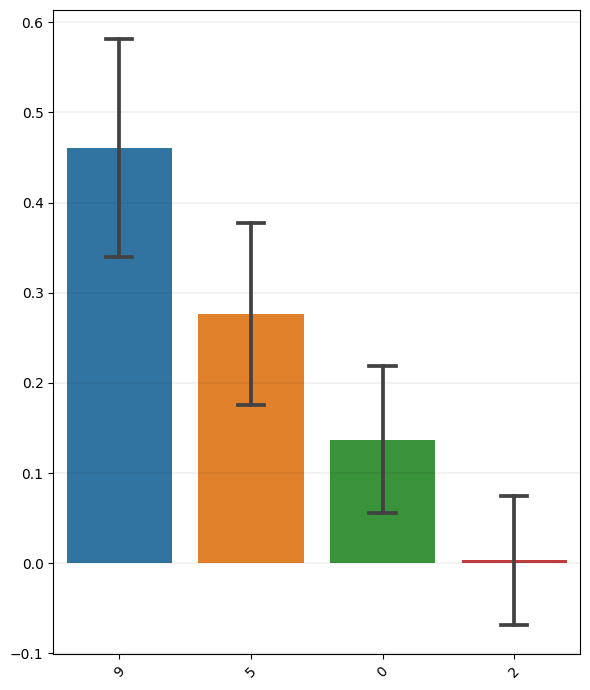

In [89]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
labels = [x.split('_')[1] for x in df[df.columns[pd.Series(df.columns).str.startswith('seed_')]].columns.to_list()]
sns.barplot(data=df[df.columns[pd.Series(df.columns).str.startswith('seed_')]], 
            ax=ax, 
            estimator=np.mean, errorbar=('sd'), capsize=.2)
ax.set_xticklabels(labels, rotation=45)

# Thresholds
#for i, (th, value) in enumerate(zip(['FMR1000_TH', 'FMR100_TH', 'FMR10_TH'], [0.25, 0.17, 0.1])):
#    ax.axhline(y = value, 
#               color = sns.color_palette("colorblind")[i], linestyle="--",
#               label = f"{th}: {value}")
#ax.legend()

plt.show()

### Evaluate attack success rate

In [37]:
df_fmr1000, df_fmr100, df_fmr10 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

for th_label, th_value in zip(['FMR1000_TH', 'FMR100_TH', 'FMR10_TH'], [0.29, 0.2, 0.11]):
    print(th_label)
    for key, value in seed_dict.items():
        # Load results
        # df_results = pd.read_csv(f"{experiment_path}/sample_img_{key}/logs/sample_images_log_{experiment_appendix}.csv")
        # Append results to dataframe
        length = len(df)
        success = len(df[df[f'seed_{key}'] > th_value])
        print(f"Seed: {key}     \t Attack success rate: {round(success / length * 100, 2)}%")
        if th_label == "FMR1000_TH":
            df_fmr1000[key] = [round(success / length * 100, 2)]
        elif th_label == "FMR100_TH":
            df_fmr100[key] = [round(success / length * 100, 2)]
        elif th_label == "FMR10_TH":
            df_fmr10[key] = [round(success / length * 100, 2)]
    print("\n")

FMR1000_TH
Seed: 9     	 Attack success rate: 99.73%
Seed: 5     	 Attack success rate: 75.94%
Seed: 0     	 Attack success rate: 8.97%
Seed: 2     	 Attack success rate: 0.0%


FMR100_TH
Seed: 9     	 Attack success rate: 99.97%
Seed: 5     	 Attack success rate: 95.62%
Seed: 0     	 Attack success rate: 40.13%
Seed: 2     	 Attack success rate: 0.37%


FMR10_TH
Seed: 9     	 Attack success rate: 100.0%
Seed: 5     	 Attack success rate: 99.73%
Seed: 0     	 Attack success rate: 81.72%
Seed: 2     	 Attack success rate: 7.24%




In [38]:
df_fmr1000.T.mean().to_list()[0]

46.160000000000004

In [39]:
permutation_complexity = [0, 
                          2, 
                         3,
                         4]

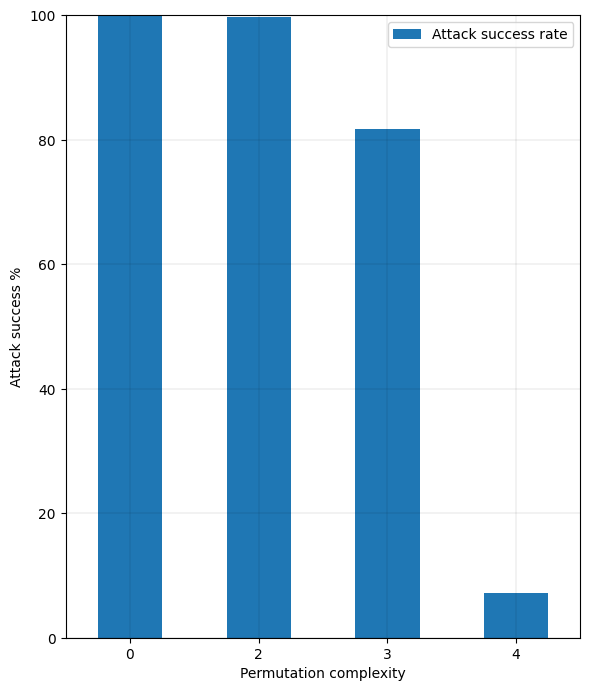

In [40]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr10.T.plot(kind='bar', ax=ax,  label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
#ax.axhline(y = df_fmr10.T.mean().to_list()[0], 
#           color = sns.color_palette("colorblind")[3], linestyle="--",
#           label = f"Mean attack rate")
ax.set_xticklabels([f"{complexity}" for seed, complexity in zip(df_fmr10.columns.to_list(), permutation_complexity)], rotation=0)
ax.set_ylim([0, 100])
#ax.annotate(f'Mean: {round(df_fmr10.T.mean().to_list()[0], 2)}%', (21, 55), ha='center', fontweight='normal', fontsize=9, c=sns.color_palette("colorblind")[3])
ax.set_xlabel("Permutation complexity")
ax.set_ylabel("Attack success %")
plt.savefig(f'random_seed_investigation/seed_{face_extractor}_128_th10.svg', bbox_inches='tight')
plt.show()

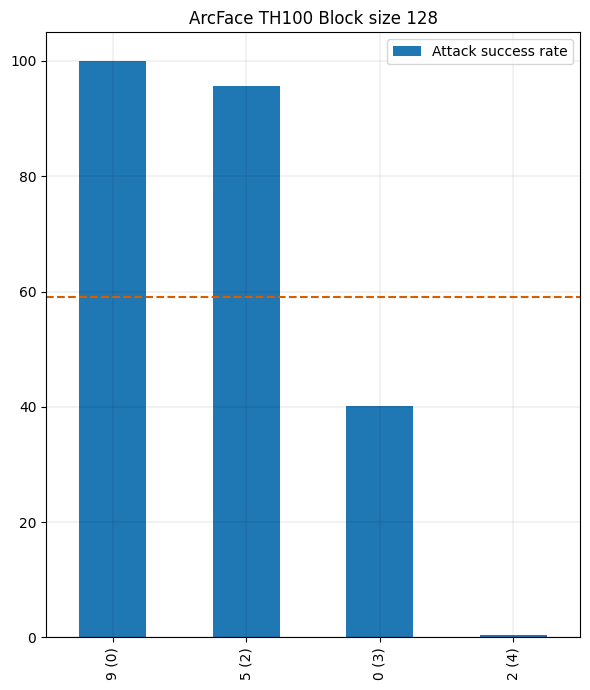

In [42]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr100.T.plot(kind='bar', ax=ax,  title="ArcFace TH100 Block size 128", label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
ax.axhline(y = df_fmr100.T.mean().to_list()[0], 
           color = sns.color_palette("colorblind")[3], linestyle="--",
           label = f"Mean attack rate")
ax.set_xticklabels([f"{seed} ({complexity})" for seed, complexity in zip(df_fmr100.columns.to_list(), permutation_complexity)])
ax.annotate(f'Mean: {round(df_fmr100.T.mean().to_list()[0], 2)}%', (21, 38), ha='center', fontweight='normal', fontsize=9, c=sns.color_palette("colorblind")[3])
plt.show()

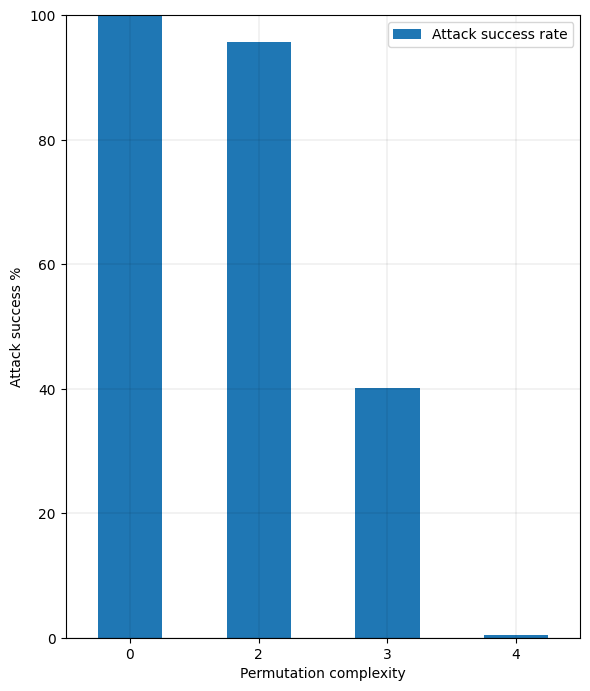

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr100.T.plot(kind='bar', ax=ax,  label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
#ax.axhline(y = df_fmr10.T.mean().to_list()[0], 
#           color = sns.color_palette("colorblind")[3], linestyle="--",
#           label = f"Mean attack rate")
ax.set_xticklabels([f"{complexity}" for seed, complexity in zip(df_fmr100.columns.to_list(), permutation_complexity)], rotation=0)
ax.set_ylim([0, 100])
#ax.annotate(f'Mean: {round(df_fmr10.T.mean().to_list()[0], 2)}%', (21, 55), ha='center', fontweight='normal', fontsize=9, c=sns.color_palette("colorblind")[3])
ax.set_xlabel("Permutation complexity")
ax.set_ylabel("Attack success %")
plt.savefig(f'random_seed_investigation/seed_{face_extractor}_128_th100.svg', bbox_inches='tight')
plt.show()

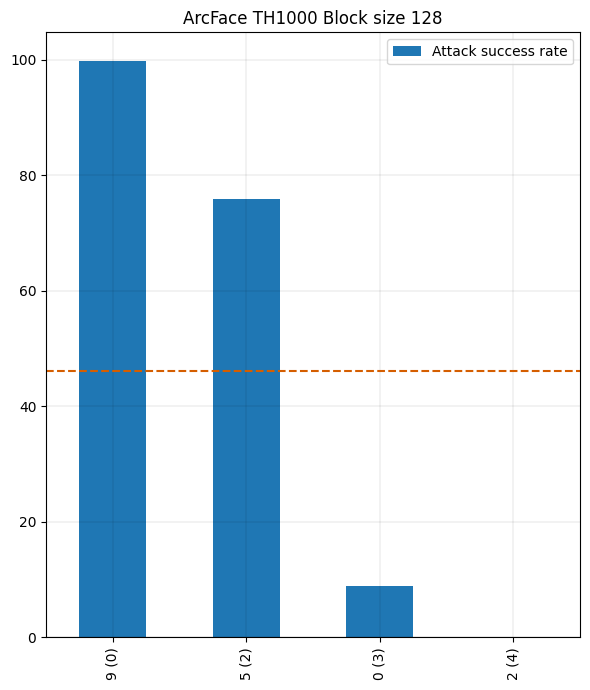

In [43]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr1000.T.plot(kind='bar', ax=ax,  title="ArcFace TH1000 Block size 128", label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
ax.axhline(y = df_fmr1000.T.mean().to_list()[0], 
           color = sns.color_palette("colorblind")[3], linestyle="--",
           label = f"Mean attack rate")
ax.set_xticklabels([f"{seed} ({complexity})" for seed, complexity in zip(df_fmr1000.columns.to_list(), permutation_complexity)])
ax.annotate(f'Mean: {round(df_fmr1000.T.mean().to_list()[0], 2)}%', (21, 22), ha='center', fontweight='normal', fontsize=9, c=sns.color_palette("colorblind")[3])
plt.show()

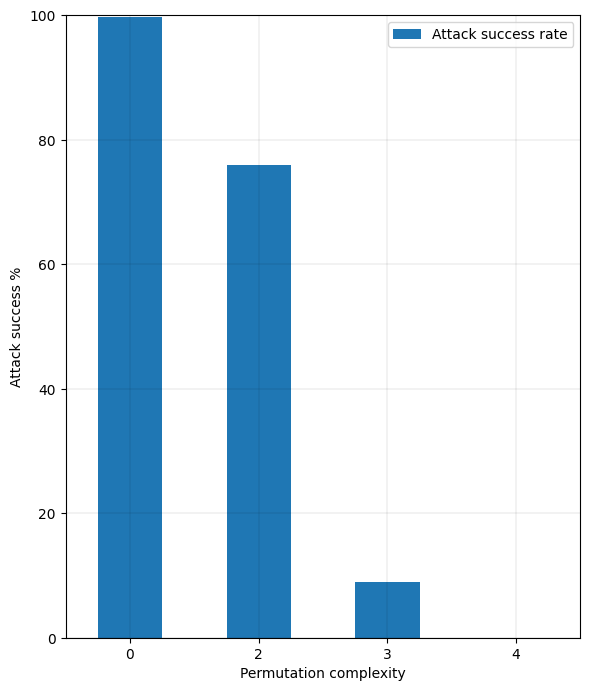

In [44]:
fig, ax = plt.subplots(1, 1, figsize = (6, 7), tight_layout = True)
df_fmr1000.T.plot(kind='bar', ax=ax,  label='seed')
ax.grid(visible=True, which='major', color='black', linewidth=0.075)
ax.legend(["Attack success rate"])
#ax.axhline(y = df_fmr10.T.mean().to_list()[0], 
#           color = sns.color_palette("colorblind")[3], linestyle="--",
#           label = f"Mean attack rate")
ax.set_xticklabels([f"{complexity}" for seed, complexity in zip(df_fmr1000.columns.to_list(), permutation_complexity)], rotation=0)
ax.set_ylim([0, 100])
#ax.annotate(f'Mean: {round(df_fmr10.T.mean().to_list()[0], 2)}%', (21, 55), ha='center', fontweight='normal', fontsize=9, c=sns.color_palette("colorblind")[3])
ax.set_xlabel("Permutation complexity")
ax.set_ylabel("Attack success %")
plt.savefig(f'random_seed_investigation/seed_{face_extractor}_128_th1000.svg', bbox_inches='tight')
plt.show()

### Export

In [23]:
# Original data frame

df

,img_original,img_original_quality,embedding_original_arcface,gender_official,filename,embedding_original_elasticface,seed_9,seed_5,seed_0,seed_2
0,../data/lfw_align/Aaron_Eckhart/Aaron_Eckhart_0001.png,0.785188,../data/features_cleaner/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy,0.523,0.317,0.131,-0.013
1,../data/lfw_align/Aaron_Guiel/Aaron_Guiel_0001.png,0.764814,../data/features_cleaner/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy,0.446,0.292,0.073,-0.066
2,../data/lfw_align/Aaron_Patterson/Aaron_Patterson_0001.png,0.737193,../data/features_cleaner/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy,0.651,0.426,0.155,-0.077
3,../data/lfw_align/Aaron_Peirsol/Aaron_Peirsol_0004.png,0.810206,../data/features_cleaner/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy,0.631,0.240,0.154,-0.086
4,../data/lfw_align/Aaron_Pena/Aaron_Pena_0001.png,0.829048,../data/features_cleaner/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy,0.714,0.542,-0.057,0.094
...,...,...,...,...,...,...,...,...,...,...
2937,../data/lfw_align/Zelma_Novelo/Zelma_Novelo_0001.png,0.834612,../data/features_cleaner/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy,0.706,0.411,0.259,0.036
2938,../data/lfw_align/Zhang_Ziyi/Zhang_Ziyi_0003.png,0.696282,../data/features_cleaner/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy,0.376,0.306,0.100,0.038
2939,../data/lfw_align/Zoe_Ball/Zoe_Ball_0001.png,0.779261,../data/features_cleaner/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy,0.630,0.333,0.092,-0.018
2940,../data/lfw_align/Zorica_Radovic/Zorica_Radovic_0001.png,0.741519,../data/features_cleaner/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy,0.634,0.426,0.200,0.026


In [24]:
df_export = df[['embedding_original_elasticface', 'gender_official', 'filename', 'seed_5']]

In [25]:
df_export.rename(columns={'seed_5': 'cos_sim_permutation_complexity_2'}, inplace=True)
df_export['embedding_pemiu_128_seed5'] = df_export['filename'].apply(lambda x: f"{experiment_path}embedding_seed_5/{x}.npy")

/tmp/ipykernel_1307/2550497840.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export.rename(columns={'seed_5': 'cos_sim_permutation_complexity_2'}, inplace=True)
/tmp/ipykernel_1307/2550497840.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_export['embedding_pemiu_128_seed5'] = df_export['filename'].apply(lambda x: f"{experiment_path}embedding_seed_5/{x}.npy")


In [26]:
# Include filepath for image reconstructions at permutation complexity 2

df_results_seed_5 = pd.read_csv(f"{experiment_path}/sample_img_5/logs/sample_images_log_exp14.csv")

In [27]:
df_results_seed_5.rename(columns={'filename': 'reconstructed_img_from_embedding_perm_compl_2'}, inplace=True)
df_results_seed_5

,reconstructed_img_from_embedding_perm_compl_2,MAE,Cosine Distance Bona Fide Embedding vs Input Embedding,Cosine Distance Bona Fide Embedding vs Synthesised Image Embedding
0,Aaron_Eckhart_0001_exp14_0000.png,0.247156,0.441,0.317
1,Aaron_Guiel_0001_exp14_0001.png,0.248513,0.490,0.292
2,Aaron_Patterson_0001_exp14_0002.png,0.192960,0.458,0.426
3,Aaron_Peirsol_0004_exp14_0003.png,0.217782,0.488,0.240
4,Aaron_Pena_0001_exp14_0004.png,0.236386,0.524,0.542
...,...,...,...,...
2938,Zelma_Novelo_0001_exp14_0026.png,0.293479,0.494,0.411
2939,Zhang_Ziyi_0003_exp14_0027.png,0.384665,0.521,0.306
2940,Zoe_Ball_0001_exp14_0028.png,0.217645,0.575,0.333
2941,Zorica_Radovic_0001_exp14_0029.png,0.300039,0.514,0.426


In [30]:
df_results_seed_5['filename'] = df_results_seed_5['reconstructed_img_from_embedding_perm_compl_2'].apply(lambda x: x.split('_exp14_')[0])
df_results_seed_5

,reconstructed_img_from_embedding_perm_compl_2,MAE,Cosine Distance Bona Fide Embedding vs Input Embedding,Cosine Distance Bona Fide Embedding vs Synthesised Image Embedding,filename
0,Aaron_Eckhart_0001_exp14_0000.png,0.247156,0.441,0.317,Aaron_Eckhart_0001
1,Aaron_Guiel_0001_exp14_0001.png,0.248513,0.490,0.292,Aaron_Guiel_0001
2,Aaron_Patterson_0001_exp14_0002.png,0.192960,0.458,0.426,Aaron_Patterson_0001
3,Aaron_Peirsol_0004_exp14_0003.png,0.217782,0.488,0.240,Aaron_Peirsol_0004
4,Aaron_Pena_0001_exp14_0004.png,0.236386,0.524,0.542,Aaron_Pena_0001
...,...,...,...,...,...
2938,Zelma_Novelo_0001_exp14_0026.png,0.293479,0.494,0.411,Zelma_Novelo_0001
2939,Zhang_Ziyi_0003_exp14_0027.png,0.384665,0.521,0.306,Zhang_Ziyi_0003
2940,Zoe_Ball_0001_exp14_0028.png,0.217645,0.575,0.333,Zoe_Ball_0001
2941,Zorica_Radovic_0001_exp14_0029.png,0.300039,0.514,0.426,Zorica_Radovic_0001


In [32]:
df_export = df_export.merge(df_results_seed_5[['filename', 'reconstructed_img_from_embedding_perm_compl_2']], on='filename')
df_export

,embedding_original_elasticface,gender_official,filename,cos_sim_permutation_complexity_2,embedding_pemiu_128_seed5,reconstructed_img_from_embedding_perm_compl_2
0,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,0.317,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Eckhart_0001.npy,Aaron_Eckhart_0001_exp14_0000.png
1,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,0.292,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Guiel_0001.npy,Aaron_Guiel_0001_exp14_0001.png
2,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,0.426,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Patterson_0001.npy,Aaron_Patterson_0001_exp14_0002.png
3,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,0.240,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Peirsol_0004.npy,Aaron_Peirsol_0004_exp14_0003.png
4,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,0.542,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Pena_0001.npy,Aaron_Pena_0001_exp14_0004.png
...,...,...,...,...,...,...
2937,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,0.411,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zelma_Novelo_0001.npy,Zelma_Novelo_0001_exp14_0026.png
2938,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,0.306,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zhang_Ziyi_0003.npy,Zhang_Ziyi_0003_exp14_0027.png
2939,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,0.333,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zoe_Ball_0001.npy,Zoe_Ball_0001_exp14_0028.png
2940,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,0.426,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zorica_Radovic_0001.npy,Zorica_Radovic_0001_exp14_0029.png


In [34]:
df_export['reconstructed_img_from_embedding_perm_compl_2'] = df_export['reconstructed_img_from_embedding_perm_compl_2'].apply(lambda x: f'{experiment_path}sample_img_5/{x}')
df_export

,embedding_original_elasticface,gender_official,filename,cos_sim_permutation_complexity_2,embedding_pemiu_128_seed5,reconstructed_img_from_embedding_perm_compl_2
0,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,0.317,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Eckhart_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Eckhart_0001_exp14_0000.png
1,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,0.292,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Guiel_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Guiel_0001_exp14_0001.png
2,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,0.426,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Patterson_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Patterson_0001_exp14_0002.png
3,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,0.240,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Peirsol_0004.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Peirsol_0004_exp14_0003.png
4,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,0.542,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Pena_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Pena_0001_exp14_0004.png
...,...,...,...,...,...,...
2937,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,0.411,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zelma_Novelo_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Zelma_Novelo_0001_exp14_0026.png
2938,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,0.306,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zhang_Ziyi_0003.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Zhang_Ziyi_0003_exp14_0027.png
2939,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,0.333,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zoe_Ball_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Zoe_Ball_0001_exp14_0028.png
2940,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,0.426,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zorica_Radovic_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Zorica_Radovic_0001_exp14_0029.png


In [37]:
# Generate embeddings from reconstructed images
gen_emb = GenerateEmbeddings()
path = f'{experiment_path}sample_img_5_embeddings'
os.makedirs(path, exist_ok=True)

for image, filename in zip(df_export['reconstructed_img_from_embedding_perm_compl_2'].tolist(), df_export['filename'].tolist()):
    embedding = gen_emb.embedding_from_img(image)
    np.save(f"{path}/{filename}.npy", embedding)

The torch device is: cuda


In [38]:
df_export['embeddings_from_reconsutrcted_img'] = df_export['filename'].apply(lambda x: f'{experiment_path}sample_img_5_embeddings/{x}.npy')
df_export

,embedding_original_elasticface,gender_official,filename,cos_sim_permutation_complexity_2,embedding_pemiu_128_seed5,reconstructed_img_from_embedding_perm_compl_2,embeddings_from_reconsutrcted_img
0,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,0.317,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Eckhart_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Eckhart_0001_exp14_0000.png,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5_embeddings/Aaron_Eckhart_0001.npy
1,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,0.292,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Guiel_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Guiel_0001_exp14_0001.png,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5_embeddings/Aaron_Guiel_0001.npy
2,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,0.426,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Patterson_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Patterson_0001_exp14_0002.png,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5_embeddings/Aaron_Patterson_0001.npy
3,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,0.240,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Peirsol_0004.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Peirsol_0004_exp14_0003.png,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5_embeddings/Aaron_Peirsol_0004.npy
4,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,0.542,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Aaron_Pena_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Aaron_Pena_0001_exp14_0004.png,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5_embeddings/Aaron_Pena_0001.npy
...,...,...,...,...,...,...,...
2937,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,0.411,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zelma_Novelo_0001.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Zelma_Novelo_0001_exp14_0026.png,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5_embeddings/Zelma_Novelo_0001.npy
2938,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,0.306,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zhang_Ziyi_0003.npy,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5/Zhang_Ziyi_0003_exp14_0027.png,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/sample_img_5_embeddings/Zhang_Ziyi_0003.npy
2939,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,0.333,../recreate_icip2022_face_reconstruction/experiments/experiment_14_pemiu_random_128_elasticface/embedding_seed_5/Zoe_Ball_0001.npy,../recreate

In [39]:
# Export

face_extractor_name = 'elasticface' 
export_path = f"../export/{face_extractor_name}_pemiu128_permcomp2_balanced"
os.makedirs(export_path, exist_ok=True)

os.makedirs(f'{export_path}/embeddings_original', exist_ok=True)
os.makedirs(f'{export_path}/embeddings_pemiu', exist_ok=True)
os.makedirs(f'{export_path}/reconstructed_img', exist_ok=True)
os.makedirs(f'{export_path}/embeddings_from_reconstructed_img', exist_ok=True)

In [41]:
# Copy files to export location

for element in df_export['embedding_original_elasticface'].tolist():
    shutil.copy(element, f'{export_path}/embeddings_original')
    
for element in df_export['embedding_pemiu_128_seed5'].tolist():
    shutil.copy(element, f'{export_path}/embeddings_pemiu')
    
for element in df_export['reconstructed_img_from_embedding_perm_compl_2'].tolist():
    shutil.copy(element, f'{export_path}/reconstructed_img')
    
for element in df_export['embeddings_from_reconsutrcted_img'].tolist():
    shutil.copy(element, f'{export_path}/embeddings_from_reconstructed_img')

In [43]:
# Modify dataframe to include relative filepaths

df_export['embedding_original_arcface'] = df_export['embedding_original_elasticface'].apply(lambda x: f"./embeddings_original/{x.split('/')[-1]}")
df_export['embedding_pemiu_128_seed5'] = df_export['embedding_pemiu_128_seed5'].apply(lambda x: f"./embeddings_pemiu/{x.split('/')[-1]}")
df_export['reconstructed_img_from_embedding_perm_compl_2'] = df_export['reconstructed_img_from_embedding_perm_compl_2'].apply(lambda x: f"./reconstructed_img/{x.split('/')[-1]}")
df_export['embeddings_from_reconsutrcted_img'] = df_export['embeddings_from_reconsutrcted_img'].apply(lambda x: f"./embeddings_from_reconstructed_img/{x.split('/')[-1]}")
df_export

,embedding_original_elasticface,gender_official,filename,cos_sim_permutation_complexity_2,embedding_pemiu_128_seed5,reconstructed_img_from_embedding_perm_compl_2,embeddings_from_reconsutrcted_img,embedding_original_arcface
0,../data/lfw_align_embeddings_elastic/Aaron_Eckhart_0001.npy,M,Aaron_Eckhart_0001,0.317,./embeddings_pemiu/Aaron_Eckhart_0001.npy,./reconstructed_img/Aaron_Eckhart_0001_exp14_0000.png,./embeddings_from_reconstructed_img/Aaron_Eckhart_0001.npy,./embeddings_original/Aaron_Eckhart_0001.npy
1,../data/lfw_align_embeddings_elastic/Aaron_Guiel_0001.npy,M,Aaron_Guiel_0001,0.292,./embeddings_pemiu/Aaron_Guiel_0001.npy,./reconstructed_img/Aaron_Guiel_0001_exp14_0001.png,./embeddings_from_reconstructed_img/Aaron_Guiel_0001.npy,./embeddings_original/Aaron_Guiel_0001.npy
2,../data/lfw_align_embeddings_elastic/Aaron_Patterson_0001.npy,M,Aaron_Patterson_0001,0.426,./embeddings_pemiu/Aaron_Patterson_0001.npy,./reconstructed_img/Aaron_Patterson_0001_exp14_0002.png,./embeddings_from_reconstructed_img/Aaron_Patterson_0001.npy,./embeddings_original/Aaron_Patterson_0001.npy
3,../data/lfw_align_embeddings_elastic/Aaron_Peirsol_0004.npy,M,Aaron_Peirsol_0004,0.240,./embeddings_pemiu/Aaron_Peirsol_0004.npy,./reconstructed_img/Aaron_Peirsol_0004_exp14_0003.png,./embeddings_from_reconstructed_img/Aaron_Peirsol_0004.npy,./embeddings_original/Aaron_Peirsol_0004.npy
4,../data/lfw_align_embeddings_elastic/Aaron_Pena_0001.npy,M,Aaron_Pena_0001,0.542,./embeddings_pemiu/Aaron_Pena_0001.npy,./reconstructed_img/Aaron_Pena_0001_exp14_0004.png,./embeddings_from_reconstructed_img/Aaron_Pena_0001.npy,./embeddings_original/Aaron_Pena_0001.npy
...,...,...,...,...,...,...,...,...
2937,../data/lfw_align_embeddings_elastic/Zelma_Novelo_0001.npy,F,Zelma_Novelo_0001,0.411,./embeddings_pemiu/Zelma_Novelo_0001.npy,./reconstructed_img/Zelma_Novelo_0001_exp14_0026.png,./embeddings_from_reconstructed_img/Zelma_Novelo_0001.npy,./embeddings_original/Zelma_Novelo_0001.npy
2938,../data/lfw_align_embeddings_elastic/Zhang_Ziyi_0003.npy,F,Zhang_Ziyi_0003,0.306,./embeddings_pemiu/Zhang_Ziyi_0003.npy,./reconstructed_img/Zhang_Ziyi_0003_exp14_0027.png,./embeddings_from_reconstructed_img/Zhang_Ziyi_0003.npy,./embeddings_original/Zhang_Ziyi_0003.npy
2939,../data/lfw_align_embeddings_elastic/Zoe_Ball_0001.npy,F,Zoe_Ball_0001,0.333,./embeddings_pemiu/Zoe_Ball_0001.npy,./reconstructed_img/Zoe_Ball_0001_exp14_0028.png,./embeddings_from_reconstructed_img/Zoe_Ball_0001.npy,./embeddings_original/Zoe_Ball_0001.npy
2940,../data/lfw_align_embeddings_elastic/Zorica_Radovic_0001.npy,F,Zorica_Radovic_0001,0.426,./embeddings_pemiu/Zorica_Radovic_0001.npy,./reconstructed_img/Zorica_Radovic_0001_exp14_0029.png,./embeddings_from_reconstructed_img/Zorica_Radovic_0001.npy,./embeddings_original/Zorica_Radovic_0001.npy


In [44]:
df_export.to_csv(f"{export_path}/dataframe.csv")